# Train model to detect attacks in CWT images with S4 model

## Import libs

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from models.s4.s4 import S4Block as S4  # Can use full version instead of minimal S4D standalone below
from models.s4.s4d import S4D
# from tqdm.auto import tqdm

from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score



### Variable Define

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# data
dataset = 'cifar10'
grayscale = False

# S4 parameters

d_model= 128
n_layers= 4
dropout= 0.1
prenorm= False


# Hyper traning Parameters
batch_size = 64
num_workers = 4
lr = 0.01
resume = False

weight_decay = 0.01
epochs= 10

# Macro Configuration
train_model = False

## Verify Enviroment

In [3]:
# Check if PyTorch is installed
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Check the name of the GPU
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("No GPU found.")

PyTorch version: 2.5.1+cu124
CUDA available: True
GPU name: NVIDIA RTX 2000 Ada Generation Laptop GPU


## Function Define

### General functions

In [4]:
def split_train_val(train, val_split):
    train_len = int(len(train) * (1.0-val_split))
    train, val = torch.utils.data.random_split(
        train,
        (train_len, len(train) - train_len),
        generator=torch.Generator().manual_seed(42),
    )
    return train, val

def setup_optimizer(model, lr, weight_decay, epochs):
    """
    S4 requires a specific optimizer setup.

    The S4 layer (A, B, C, dt) parameters typically
    require a smaller learning rate (typically 0.001), with no weight decay.

    The rest of the model can be trained with a higher learning rate (e.g. 0.004, 0.01)
    and weight decay (if desired).
    """

    # All parameters in the model
    all_parameters = list(model.parameters())

    # General parameters don't contain the special _optim key
    params = [p for p in all_parameters if not hasattr(p, "_optim")]

    # Create an optimizer with the general parameters
    optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)

    # Add parameters with special hyperparameters
    hps = [getattr(p, "_optim") for p in all_parameters if hasattr(p, "_optim")]
    hps = [
        dict(s) for s in sorted(list(dict.fromkeys(frozenset(hp.items()) for hp in hps)))
    ]  # Unique dicts
    for hp in hps:
        params = [p for p in all_parameters if getattr(p, "_optim", None) == hp]
        optimizer.add_param_group(
            {"params": params, **hp}
        )

    # Create a lr scheduler
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # Print optimizer info
    keys = sorted(set([k for hp in hps for k in hp.keys()]))
    for i, g in enumerate(optimizer.param_groups):
        group_hps = {k: g.get(k, None) for k in keys}
        print(' | '.join([
            f"Optimizer group {i}",
            f"{len(g['params'])} tensors",
        ] + [f"{k} {v}" for k, v in group_hps.items()]))

    return optimizer, scheduler

## Preparation

In [5]:
# Dropout broke in PyTorch 1.11
if tuple(map(int, torch.__version__.split('.')[:2])) == (1, 11):
    print("WARNING: Dropout is bugged in PyTorch 1.11. Results may be worse.")
    dropout_fn = nn.Dropout
if tuple(map(int, torch.__version__.split('.')[:2])) >= (1, 12):
    dropout_fn = nn.Dropout1d
else:
    dropout_fn = nn.Dropout2d

## Preprocessing of the dataset

### download dataset

In [6]:
print("preparing data")

if dataset == 'cifar10':

    if grayscale:
        transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(mean=122.6 / 255.0, std=61.0 / 255.0),
            transforms.Lambda(lambda x: x.view(1, 1024).t())
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            transforms.Lambda(lambda x: x.view(3, 1024).t())
        ])

    # S4 is trained on sequences with no data augmentation!
    transform_train = transform_test = transform

    trainset = torchvision.datasets.CIFAR10(
        root='./data/cifar/', train=True, download=True, transform=transform_train)
    trainset, _ = split_train_val(trainset, val_split=0.1)

    valset = torchvision.datasets.CIFAR10(
        root='./data/cifar/', train=True, download=True, transform=transform_test)
    _, valset = split_train_val(valset, val_split=0.1)

    testset = torchvision.datasets.CIFAR10(
        root='./data/cifar/', train=False, download=True, transform=transform_test)

    d_input = 3 if not grayscale else 1
    d_output = 10

elif dataset == 'mnist':

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(1, 784).t())
    ])
    transform_train = transform_test = transform

    trainset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform_train)
    trainset, _ = split_train_val(trainset, val_split=0.1)

    valset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform_test)
    _, valset = split_train_val(valset, val_split=0.1)

    testset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform_test)

    d_input = 1
    d_output = 10
else: raise NotImplementedError

preparing data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### data loader

In [7]:
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size= batch_size, shuffle=True, num_workers= num_workers)
valloader = torch.utils.data.DataLoader(
    valset, batch_size= batch_size, shuffle=False, num_workers= num_workers)
testloader = torch.utils.data.DataLoader(
    testset, batch_size= batch_size, shuffle=False, num_workers= num_workers)

## Model construction

### S4 class construction

In [8]:
class S4Model(nn.Module):

    def __init__(
        self,
        d_input,
        d_output=10,
        d_model=256,
        n_layers=4,
        dropout=0.2,
        prenorm=False,
    ):
        super().__init__()

        self.prenorm = prenorm

        # Linear encoder (d_input = 1 for grayscale and 3 for RGB)
        self.encoder = nn.Linear(d_input, d_model)

        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=min(0.001, lr))
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(dropout_fn(dropout))

        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)

        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)

            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)

            # Apply S4 block: we ignore the state input and output
            z, _ = layer(z)

            # Dropout on the output of the S4 block
            z = dropout(z)

            # Residual connection
            x = z + x

            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)

        # Pooling: average pooling over the sequence length
        x = x.mean(dim=1)

        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)

        return x

### S4 class implementation

In [9]:
# Model
print('==> Building model..')
model = S4Model(
    d_input=d_input,
    d_output=d_output,
    d_model= d_model,
    n_layers= n_layers,
    dropout= dropout,
    prenorm= prenorm,
)

model = model.to(device)

if device == 'cuda':
    cudnn.benchmark = True

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer, scheduler = setup_optimizer(
    model, lr=lr, weight_decay=weight_decay, epochs=epochs
)


==> Building model..
Optimizer group 0 | 28 tensors | lr 0.01 | weight_decay 0.01
Optimizer group 1 | 12 tensors | lr 0.001 | weight_decay 0.0


## Model Training

In [ ]:
def train():
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        pbar.set_description(
            'Batch Idx: (%d/%d) | Loss: %.3f | Acc: %.3f%% (%d/%d)' %
            (batch_idx, len(trainloader), train_loss/(batch_idx+1), 100.*correct/total, correct, total)
        )


def eval(epoch, dataloader, checkpoint=False):
    global best_acc
    model.eval()
    eval_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(dataloader))
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            eval_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            pbar.set_description(
                'Batch Idx: (%d/%d) | Loss: %.3f | Acc: %.3f%% (%d/%d)' %
                (batch_idx, len(dataloader), eval_loss/(batch_idx+1), 100.*correct/total, correct, total)
            )

    # Save checkpoint.
    if checkpoint:
        acc = 100.*correct/total
        if acc > best_acc:
            state = {
                'model': model.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
            best_acc = acc

        return acc
if train_model:
    print('==> Training model..')
    pbar = tqdm(range(start_epoch, epochs), desc='Training Progress')
    for epoch in pbar:
        if epoch == 0:
            pbar.set_description(f'Epoch: {epoch}')
        else:
            pbar.set_description(f'Epoch: {epoch} | Val acc: {val_acc:.3f}')
        
        train()
        val_acc = eval(epoch, valloader, checkpoint=True)
        eval(epoch, testloader)
        scheduler.step()
        # print(f"Epoch {epoch} learning rate: {scheduler.get_last_lr()}")
    

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Model Save

In [17]:
# Save the model
torch.save(model.state_dict(), 's4_cifar10.pth')


## Model Evaluation

        

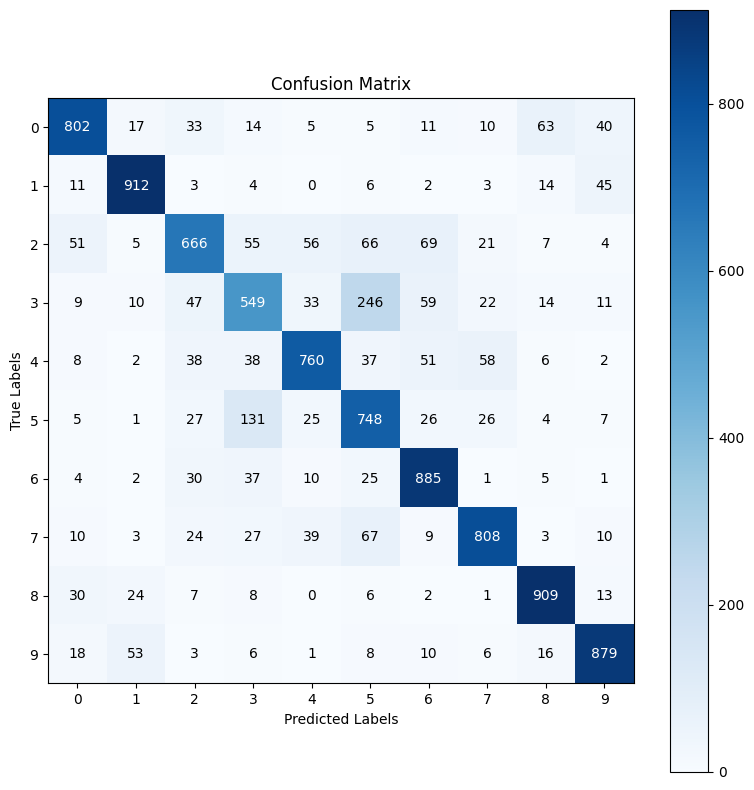

Confusion Matrix:
[[802  17  33  14   5   5  11  10  63  40]
 [ 11 912   3   4   0   6   2   3  14  45]
 [ 51   5 666  55  56  66  69  21   7   4]
 [  9  10  47 549  33 246  59  22  14  11]
 [  8   2  38  38 760  37  51  58   6   2]
 [  5   1  27 131  25 748  26  26   4   7]
 [  4   2  30  37  10  25 885   1   5   1]
 [ 10   3  24  27  39  67   9 808   3  10]
 [ 30  24   7   8   0   6   2   1 909  13]
 [ 18  53   3   6   1   8  10   6  16 879]]
Accuracy (Acc): 0.7918
F1 Score (F1): 0.7907
Sensitivity (Sen/Recall): 0.7918
Precision: 0.7931
Specificity (Spe): 0.9769


In [ ]:
# 确保模型切换到评估模式
model.eval()

# 准备存储真实标签和预测标签
y_true = []
y_pred = []

# 使用 GPU 进行推理
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)  # 确保数据在 GPU 上
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(targets.cpu().numpy())  # 将 GPU 数据转为 CPU 后的 numpy 数组
        y_pred.extend(predicted.cpu().numpy())

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 可视化混淆矩阵并在图像上显示具体数值
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# 添加坐标轴标签
num_classes = cm.shape[0]
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# 在每个格子上显示数值
threshold = cm.max() / 2.  # 设置数值显示颜色的阈值
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f'{cm[i, j]}',
                 ha="center", va="center",
                 color="white" if cm[i, j] > threshold else "black")

plt.tight_layout()
plt.show()

# # 打印混淆矩阵
# print("Confusion Matrix:")
# print(cm)

# 计算性能指标
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')  # 使用加权平均支持多类别
sensitivity = recall_score(y_true, y_pred, average='weighted')  # Sensitivity == Recall
precision = precision_score(y_true, y_pred, average='weighted')  # 加权 Precision

# Specificity 是针对每一类计算的，这里提供一个总体计算方法
specificity_per_class = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])  # 真负例
    fp = cm[:, i].sum() - cm[i, i]  # 假正例
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificity_per_class.append(specificity)
specificity_avg = np.mean(specificity_per_class)  # 平均 Specificity

# 打印指标
print("Confusion Matrix:")
print(cm)
print(f"Accuracy (Acc): {accuracy:.4f}")
print(f"F1 Score (F1): {f1:.4f}")
print(f"Sensitivity (Sen/Recall): {sensitivity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Specificity (Spe): {specificity_avg:.4f}")



## Load Model and test